**Notas para contenedor de docker:**

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

```
docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_numerical -p 8888:8888 -d palmoreck/jupyterlab_numerical:1.1.0
```

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

```
docker stop jupyterlab_numerical
```


Documentación de la imagen de docker `palmoreck/jupyterlab_numerical:1.1.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/numerical).

---

Nota basada en [liga1](https://drive.google.com/file/d/1xtkxPCx05Xg4Dj7JZoQ-LusBDrtYUqOF/view?usp=sharing), [liga2](https://drive.google.com/file/d/16-_PvWNaO0Zc9x04-SRsxCRdn5fxebf2/view?usp=sharing)

En esta nota se consideran resolver problemas de la forma:

$$\min f_o(x)$$

con $f_o:\mathbb{R}^n \rightarrow \mathbb{R}$ fuertemente convexa y $f_o \in \mathcal{C}^2(\text{dom}f_o)$ para buscar óptimos locales. Además se asume que los puntos iniciales $x^{(0)}$ de los métodos iterativos están en $\text{dom}f_o$ y los conjuntos $f_o(x^{(0)})$-subnivel son conjuntos cerrados. Ver [1.4.Polinomios_de_Taylor_y_diferenciacion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.4.Polinomios_de_Taylor_y_diferenciacion_numerica.ipynb) y [4.1.Optimizacion_numerica_y_machine_learning](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.1.Optimizacion_numerica_y_machine_learning.ipynb) para definiciones utilizadas en esta nota.

También se asume que existe un punto óptimo $x^*$ por lo que el problema tiene solución y el valor óptimo se denota por $p^* = f_o(x^*) = \inf f_o(x)$

Las suposición que una función $f$ sea convexa asegura que una **condición necesaria y suficiente** para que $x^*$ sea óptimo es: $\nabla f(x^*) = 0$ la cual es **en general** es un conjunto de $n$ **ecuaciones no lineales** en $n$ variables y que resuelve el problema de optimización planteado al inicio. 


# Método de descenso en gradiente

>**Algoritmo de descenso en gradiente**
>> **Dado** un **punto inicial** $x$ en $\text{dom}f_o$

>> **Repetir** el siguiente bloque para $k=0,1,2,...$

>>> 1. Calcular la dirección de descenso $\Delta x = - \nabla f_o(x)$.
>>> 2. Búsqueda de línea. Elegir un tamaño de paso $t > 0$.
>>> 3. Hacer la actualización: $x = x + t\Delta x$.

>> **hasta** convergencia (satisfacer criterio de paro).


**Nota:** los pasos en el algoritmo anterior representan una guía para la implementación. Al describirse los pasos de un algoritmo no implica que se tengan que implementar uno a continuación del otro como se describe. Si una implementación respeta la lógica y al mismo método, entonces pueden seguirse los pasos de una forma distinta.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

### Funciones auxiliares

In [2]:
def inc_index(vec,index,h):
    '''
    Auxiliary function for gradient and Hessian computation.
    Args:
        vec (array): numpy array.
        index (int): index.
        h (float):   quantity that vec[index] will be increased.
    Returns:
        vec (array): numpy array vec with vec[index] increased by h.
    '''
    vec[index] +=h
    return vec

In [3]:
def dec_index(vec,index,h=1):
    '''
    Auxiliary function for gradient and Hessian computation.
    Args:
        vec (array): numpy array.
        index (int): index.
        h (float):   quantity that vec[index] will be decreased.
    Returns:
        vec (array): numpy array vec with vec[index] decreased by h.
    '''
    vec[index] -=h
    return vec

In [4]:
def gradient_approximation(f,x,h=1e-8):
    '''
    Numerical approximation of gradient for function f using forward differences.
    Args:
        f (lambda expression): definition of function f.
        x (array): numpy array that holds values where gradient will be computed.
        h (float): step size for forward differences, tipically h=1e-8
    Returns:
        gf (array): numerical approximation to gradient of f.
    '''
    n = x.size
    gf = np.zeros(n)
    f_x = f(x)
    for i in np.arange(n):
        inc_index(x,i,h)
        gf[i] = f(x) - f_x
        dec_index(x,i,h)
    return gf/h

In [5]:
def Hessian_approximation(f,x,h=1e-6):
    '''
    Numerical approximation of Hessian for function f using forward differences.
    Args:
        f (lambda expression): definition of function f.
        x (array): numpy array that holds values where Hessian will be computed.
        h (float): step size for forward differences, tipically h=1e-6
    Returns:
        Hf (array): numerical approximation to Hessian of f.
    '''
    n = x.size
    Hf = np.zeros((n,n))
    f_x = f(x)
    for i in np.arange(n):
        inc_index(x,i,h)
        f_x_inc_in_i = f(x)
        for j in np.arange(i,n):
            inc_index(x,j,h)
            f_x_inc_in_i_j = f(x)
            dec_index(x,i,h)
            f_x_inc_in_j = f(x)
            dif = f_x_inc_in_i_j-f_x_inc_in_i-f_x_inc_in_j+f_x
            Hf[i,j] = dif
            if j != i:
                Hf[j,i] = dif
            dec_index(x,j,h)
            inc_index(x,i,h)
        dec_index(x,i,h)
    return Hf/h**2

In [6]:
def line_search_by_backtracking(f,dir_desc,x,
                                der_direct, alpha=.15, beta=.5):
    """
    Line search that sufficiently decreases f restricted to a ray in the direction dir_desc.
    Args:
        alpha (float): parameter in line search with backtracking, tipically .15
        beta (float): parameter in line search with backtracking, tipically .5
        f (lambda expression): definition of function f.
        dir_desc (array): descent direction.
        x (array): numpy array that holds values where line search will be performed.
        der_direct (float): directional derivative of f.
    Returns:
        t (float): positive number for stepsize along dir_desc that sufficiently decreases f.
    """
    t=1
    if alpha > 1/2:
        print('alpha must be less than or equal to 1/2')
        t=-1
    if beta>1:
        print('beta must be less than 1')
        t=-1;   
    if t!=-1:
        eval1 = f(x+t*dir_desc)
        eval2 = f(x) + alpha*t*der_direct
        while eval1 > eval2:
            t=beta*t
            eval1=f(x+t*dir_desc)
            eval2=f(x)+alpha*t*der_direct
    else:
        t=-1
    return t

### Descenso en gradiente

In [7]:
def compute_error(x_obj,x_approx):
    '''
    Relative error between x_obj and x_approx.
    '''
    if np.linalg.norm(x_obj) > np.nextafter(0,1):
        Err=np.linalg.norm(x_obj-x_approx)/np.linalg.norm(x_obj)
    else:
        Err=np.linalg.norm(x_obj-x_approx)
    return Err

In [8]:
def gradient_descent(f, x_0, tol, 
                     tol_backtracking, x_ast=None, p_ast=None, maxiter=30):
    '''
    Method of gradient descent to numerically approximate solution of min f.
    Args:
        f (lambda expression): definition of function f.
        x_0 (array): initial point for gradient descent method.
        tol (float): tolerance that will halt method. Controls norm of gradient of f.
        tol_backtracking (float): tolerance that will halt method. Controls value of line search by backtracking.
        x_ast (array): solution of min f, now it's required that user knows the solution...
        p_ast (float): value of f(x_ast), now it's required that user knows the solution...
        maxiter (int): maximum number of iterations
    Returns:
        x (array): numpy array, approximation of x_ast.
        iteration (int): number of iterations.
        Err_plot (array): numpy array of absolute error between p_ast and f(x) with x approximation.
                          of x_ast. Useful for plotting.
        x_plot (array): numpy array that containts in columns vector of approximations. Last column
                        contains x, approximation of solution. Useful for plotting.
    '''
    iteration = 0
    x = x_0
    
    feval = f(x)
    gfeval = gradient_approximation(f,x)

    normgf = np.linalg.norm(gfeval)
    
    Err_plot_aux = np.zeros(maxiter)
    Err_plot_aux[iteration]=math.fabs(feval-p_ast)
    
    Err = compute_error(x_ast,x)
    n = x.size
    x_plot = np.zeros((n,maxiter))
    x_plot[:,iteration] = x
    
    print('I    Normagf   Error x_ast   Error p_ast   line search')
    print('{}    {:0.2e}    {:0.2e}    {:0.2e}     {}'.format(iteration,normgf,Err,Err_plot_aux[iteration],"---"))
    iteration+=1
    while(normgf>tol and iteration < maxiter):
        dir_desc = -gfeval
        der_direct = gfeval.dot(dir_desc)
        t = line_search_by_backtracking(f,dir_desc,x,der_direct)
        x = x + t*dir_desc
        feval = f(x)
        gfeval = gradient_approximation(f,x)
        normgf = np.linalg.norm(gfeval)
        Err_plot_aux[iteration] = math.fabs(feval-p_ast);
        x_plot[:,iteration] = x
        Err = compute_error(x_ast,x)
        print('{}    {:0.2e}    {:0.2e}    {:0.2e}     {:0.2e}'.format(iteration,normgf,Err,
                                                                      Err_plot_aux[iteration],t))
        if t<tol_backtracking: #if t is less than tol_backtracking then we need to check the reason
            iter_salida=iteration
            iteration = maxiter
        iteration+=1
    print('{} {:0.2e}'.format("Error of x with respect to x_ast:",Err))
    print('{} {}'.format("Approximate solution:", x))
    cond = Err_plot_aux > np.finfo(float).eps*10**(-2)
    Err_plot = Err_plot_aux[cond]
    x_plot = x_plot[:,:iteration]
    if iteration == maxiter and t < tol_backtracking:
        print("Backtracking value less than tol_backtracking, check approximation")
        iteration=iter_salida
    return [x,iteration,Err_plot,x_plot]

## Ejemplo

1) $$\min \quad (x_1-2)^2+(2-x_2)^2+x_3^2+x_4^4$$

La solución del problema anterior es $x^* = (2,2,0,0)^T$. 

Método de descenso gradiente con $x_0=(5,5,1,0)^T$:

In [9]:
fo = lambda x: (x[0]-2)**2 + (2-x[1])**2 + x[2]**2 + x[3]**4
x_ast = np.array([2,2,0,0],dtype=float)
x_0 = np.array([5,5,1,0],dtype=float)
tol=1e-8
tol_backtracking=1e-14
maxiter=5
p_ast=fo(x_ast)
[x,total_of_iterations,Err_plot,x_plot]=gradient_descent(fo, x_0, tol, tol_backtracking, x_ast, p_ast, maxiter)

I    Normagf   Error x_ast   Error p_ast   line search
0    8.72e+00    1.54e+00    1.90e+01     ---
1    3.53e-07    6.10e-08    2.98e-14     5.00e-01
2    2.14e-15    3.06e-09    7.50e-17     5.00e-01
Error of x with respect to x_ast: 3.06e-09
Approximate solution: [ 2.e+00  2.e+00 -5.e-09  0.e+00]


In [10]:
x

array([ 2.e+00,  2.e+00, -5.e-09,  0.e+00])

In [11]:
total_of_iterations

3

In [12]:
Err_plot

array([1.90000000e+01, 2.97654832e-14, 7.49999861e-17])

In [13]:
x_plot

array([[ 5.00000000e+00,  2.00000011e+00,  2.00000000e+00],
       [ 5.00000000e+00,  2.00000011e+00,  2.00000000e+00],
       [ 1.00000000e+00, -8.27403711e-08, -5.00000000e-09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

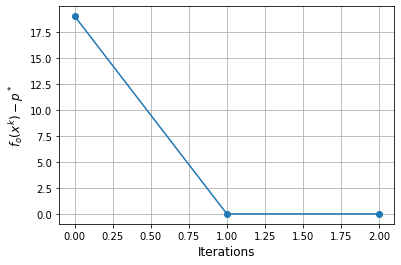

In [14]:
plt.plot(np.arange(Err_plot.size),Err_plot,'o-')
plt.ylabel('$f_o(x^k)-p^*$',size=12)
plt.xlabel('Iterations',size=12)
plt.grid()
plt.show()

**Comentario:** en esta gráfica se observa una convergencia **lineal** del método de descenso en gradiente para $f_o$.

## Ejemplo: influencia del número de condición 

2) El método de descenso en gradiente es **altamente sensible** a la forma de las curvas de nivel de la función objetivo $f_o$. Para observar esto considérese el problema: $$\min \frac{1}{2}\left(x_1^2+Cx_2^2 \right)$$

La solución del problema anterior es $x^*=(0,0)^T$.

Método de descenso en gradiente con $x_0=(0.5,0.5)^T$.

**Descenso en gradiente para caso $C=10$**

In [15]:
cte=10

In [16]:
fo = lambda x: 1/2*(x[0]**2+cte*x[1]**2)

In [17]:
x_ast=np.array([0,0],dtype=float)
x_0 = np.array([0.5,0.5],dtype=float)
tol=1e-8
tol_backtracking=1e-14
maxiter=50
p_ast=fo(x_ast)
[x,total_of_iterations,Err_plot,x_plot]=gradient_descent(fo, x_0, tol, tol_backtracking, x_ast, p_ast, maxiter)

I    Normagf   Error x_ast   Error p_ast   line search
0    5.02e+00    7.07e-01    1.38e+00     ---
1    1.32e+00    4.55e-01    1.74e-01     1.25e-01
2    4.94e-01    3.84e-01    7.82e-02     1.25e-01
3    5.50e-01    2.91e-01    5.22e-02     2.50e-01
4    2.77e-01    2.51e-01    3.22e-02     1.25e-01
5    4.85e-01    1.34e-01    1.89e-02     5.00e-01
6    1.61e-01    1.11e-01    6.73e-03     1.25e-01
7    1.94e-01    8.43e-02    4.94e-03     2.50e-01
8    8.45e-02    7.23e-02    2.70e-03     1.25e-01
9    8.53e-02    5.45e-02    1.68e-03     2.50e-01
10    1.07e-01    4.18e-02    1.31e-03     2.50e-01
11    4.33e-02    3.56e-02    6.61e-04     1.25e-01
12    4.56e-02    2.69e-02    4.23e-04     2.50e-01
13    2.51e-02    2.33e-02    2.76e-04     1.25e-01
14    3.89e-02    1.22e-02    1.37e-04     5.00e-01
15    1.38e-02    1.02e-02    5.62e-05     1.25e-01
16    1.59e-02    7.77e-03    3.89e-05     2.50e-01
17    7.54e-03    6.70e-03    2.30e-05     1.25e-01
18    1.43e-02    3.62e-

In [18]:
x

array([ 5.90613861e-07, -1.19699510e-07])

In [19]:
total_of_iterations

50

In [20]:
Err_plot.shape

(50,)

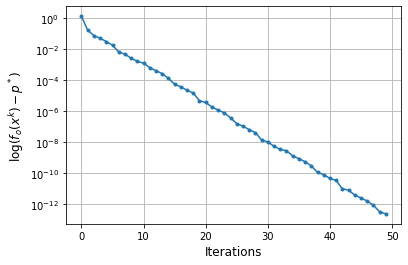

In [21]:
plt.yscale('log') #escala logarítmica en el eje vertical
plt.plot(np.arange(Err_plot.size),Err_plot,'.-')
plt.ylabel('$\log(f_o(x^k)-p^*)$',size=12)
plt.xlabel('Iterations',size=12)
plt.grid()
plt.show()

In [22]:
x_plot[:,0]

array([0.5, 0.5])

In [23]:
x_plot.shape

(2, 50)

In [24]:
x_plot[:,-1]

array([ 5.90613861e-07, -1.19699510e-07])

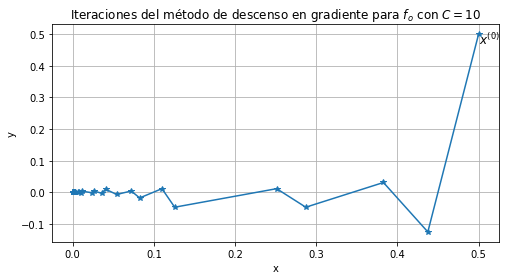

In [25]:
plt.figure(figsize=(8,4))
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.ylabel('y')
plt.xlabel('x')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12,xytext=(0.5, 0.47))
plt.title('Iteraciones del método de descenso en gradiente para $f_o$ con $C=10$')
plt.grid()
plt.show()

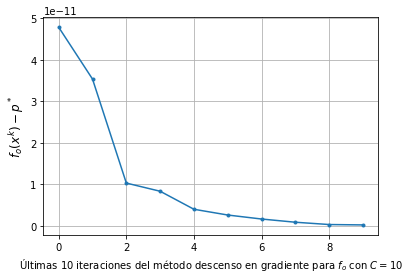

In [26]:
plt.plot(np.arange(Err_plot.size-40),Err_plot[40:],'.-')
plt.ylabel('$f_o(x^k)-p^*$',size=12)
plt.xlabel('Últimas 10 iteraciones del método descenso en gradiente para $f_o$ con $C=10$')
plt.grid()
plt.show()

**Comentario:** en esta gráfica se observa una convergencia **lineal** del método de descenso en gradiente para $f_o$.

**Curvas de nivel de $f_o$**

In [27]:
z=lambda x_mesh,y_mesh,cte: 1/2*(x_mesh**2+cte*y_mesh**2)

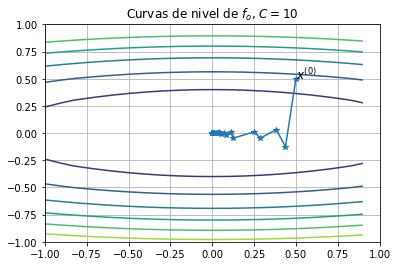

In [28]:
density=1e-1
xl=-1
yl=-1
xr=1
yr=1
x_p=np.arange(xl,xr,density)
y_p=np.arange(yl,yr,density)
x_mesh,y_mesh = np.meshgrid(x_p,y_p)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.contour(x_p,y_p,z(x_mesh,y_mesh,cte))
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.grid()
plt.title("Curvas de nivel de $f_o$, $C=10$")
plt.show()

**Curvas de nivel $C=1$**

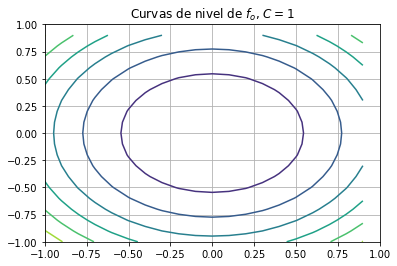

In [29]:
cte=1
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.contour(x_p,y_p,z(x_mesh,y_mesh,cte))
plt.grid()
plt.title("Curvas de nivel de $f_o$, $C=1$")
plt.show()

**Curvas de nivel $C=0.1$**

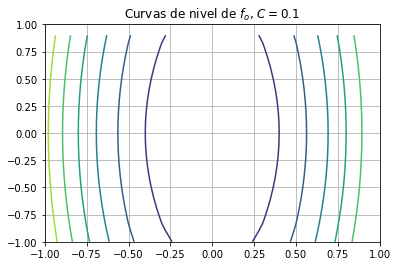

In [30]:
cte=.1
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.contour(x_p,y_p,z(x_mesh,y_mesh,cte))
plt.grid()
plt.title("Curvas de nivel de $f_o$, $C=0.1$")
plt.show()

Se puede probar que las curvas de nivel para $f_o$ bajo las suposiciones que están al inicio de esta nota tienen forma de elipsoides cerca del óptimo $x^*$ y son aproximadamente iguales al elipsoide definido como:

$$\mathcal{E}_{x^*} = \{z \in \mathbb{R}^2 : ||z-x^*||_{\nabla^2 f_o(x^*)}^2 \leq 1\}$$

\*La norma $||z||_P$ se nombra **norma cuadrática** y está definida para matrices simétricas positivas definidas $P$. La definición es: $$||z||_P = \sqrt{z^TPz}.$$

Obsérvese que $f_o(x)=\frac{1}{2}\left(x_1^2+Cx_2^2 \right)$ tiene una Hessiana igual a: $\nabla^2f(x)=\left [\begin{array}{cc}
1 & 0\\
0 & C\\
\end{array}
\right]
$ $\forall x \in \mathbb{R}^2$.

A continuación se presenta el elipsoide $\mathcal{E}_{x^{(k)}}=\{z \in \mathbb{R}^2 : ||z-x^{(k)}||_{\nabla^2 f_o(x^{(k)})}^2 \leq 1\}$ para la última iteración $x^{(k)}$ de los resultados del método de descenso en gradiente anteriores usando $C=10$:




In [31]:
cte=10

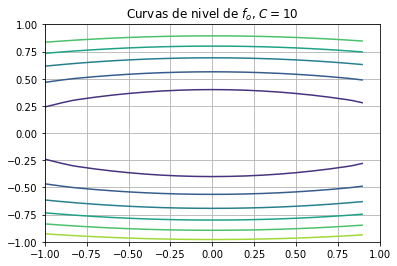

In [32]:
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.contour(x_p,y_p,z(x_mesh,y_mesh,cte))
plt.grid()
plt.title("Curvas de nivel de $f_o$, $C=10$")
plt.show()

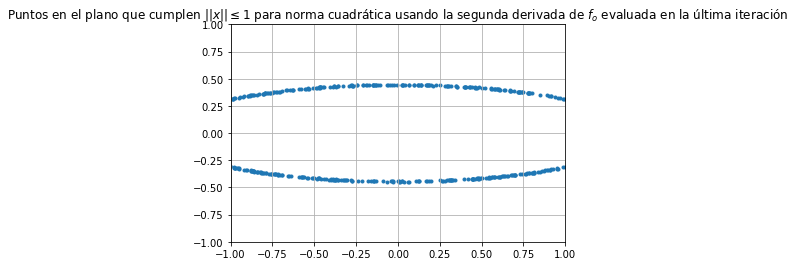

In [33]:
x_k = x_plot[:,-1].reshape(2,1)
Hf_x_k = Hessian_approximation(fo,x_k)
norm_cuad = lambda z : np.sum((z-x_k)*(Hf_x_k@(z-x_k)),axis=0)
density_p=int(2.5*10**5)
z_p=np.random.uniform(-2,2,(2,density_p))
lim_sup=2
lim_inf=1.95
ind=(norm_cuad(z_p)<=lim_sup) & (lim_inf<=norm_cuad(z_p))
z_p_subset = z_p[:,ind]
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter(z_p_subset[0,:],z_p_subset[1,:],marker='.')
plt.title('Puntos en el plano que cumplen $||x|| \leq 1$ para norma cuadrática usando la segunda derivada de $f_o$ evaluada en la última iteración')
plt.grid()
plt.show()

**Número de condición de la matriz Hessiana**

In [34]:
Hf_x_k

array([[ 1.00000000e+00, -2.01948392e-16],
       [-2.01948392e-16,  1.00000000e+01]])

In [35]:
np.linalg.cond(Hf_x_k)

10.0

**La Hessiana es medianamente bien condicionada**

**Descenso en gradiente para caso $C=1$**

In [36]:
cte=1

In [37]:
x_ast=np.array([0,0],dtype=float)
x_0 = np.array([0.5,0.5],dtype=float)
tol=1e-8
tol_backtracking=1e-14
maxiter=50
p_ast=fo(x_ast)
[x,total_of_iterations,Err_plot,x_plot]=gradient_descent(fo, x_0, tol, tol_backtracking, x_ast, p_ast, maxiter)

I    Normagf   Error x_ast   Error p_ast   line search
0    7.07e-01    7.07e-01    2.50e-01     ---
1    4.33e-09    1.14e-08    6.50e-17     1.00e+00
Error of x with respect to x_ast: 1.14e-08
Approximate solution: [-8.06349476e-09 -8.06349476e-09]


In [38]:
x

array([-8.06349476e-09, -8.06349476e-09])

In [39]:
total_of_iterations

2

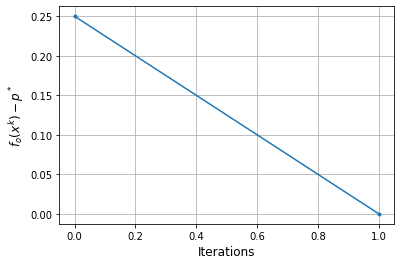

In [40]:
plt.plot(np.arange(Err_plot.size),Err_plot,'.-')
plt.ylabel('$f_o(x^k)-p^*$',size=12)
plt.xlabel('Iterations',size=12)
plt.grid()
plt.show()

**Comentario:** en esta gráfica se observa una convergencia **lineal** del método de descenso en gradiente para $f_o$ con $C=1$.

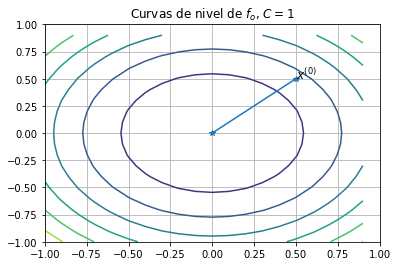

In [41]:
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.contour(x_p,y_p,z(x_mesh,y_mesh,cte))
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.title("Curvas de nivel de $f_o$, $C=1$")
plt.grid()
plt.show()

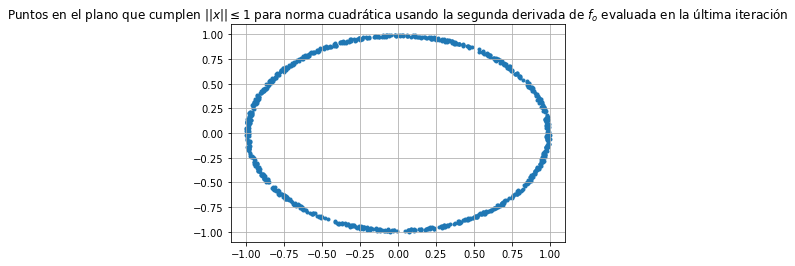

In [42]:
x_k = x_plot[:,-1].reshape(2,1)
Hf_x_k = Hessian_approximation(fo,x_k)
norm_cuad = lambda z : np.sum((z-x_k)*(Hf_x_k@(z-x_k)),axis=0)
density_p=int(2.5*10**4)
z_p=np.random.uniform(-1,1,(2,density_p))
lim_sup=1
lim_inf=.95
ind=(norm_cuad(z_p)<=lim_sup) & (lim_inf<=norm_cuad(z_p))
z_p_subset = z_p[:,ind]
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.scatter(z_p_subset[0,:],z_p_subset[1,:],marker='.')
plt.title('Puntos en el plano que cumplen $||x|| \leq 1$ para norma cuadrática usando la segunda derivada de $f_o$ evaluada en la última iteración')
plt.grid()
plt.show()

In [43]:
np.linalg.cond(Hf_x_k)

1.0

**La matriz Hessiana es bien condicionada**

**Descenso en gradiente para caso $C=0.1$**

In [44]:
cte=.1

In [45]:
x_ast=np.array([0,0],dtype=float)
x_0 = np.array([0.5,0.5],dtype=float)
tol=1e-8
tol_backtracking=1e-14
maxiter=70
p_ast=fo(x_ast)
[x,total_of_iterations,Err_plot,x_plot]=gradient_descent(fo, x_0, tol, tol_backtracking, x_ast, p_ast, maxiter)

I    Normagf   Error x_ast   Error p_ast   line search
0    5.02e-01    7.07e-01    1.38e-01     ---
1    4.50e-02    4.50e-01    1.01e-02     1.00e+00
2    4.05e-02    4.05e-01    8.20e-03     1.00e+00
3    3.65e-02    3.65e-01    6.64e-03     1.00e+00
4    3.28e-02    3.28e-01    5.38e-03     1.00e+00
5    2.95e-02    2.95e-01    4.36e-03     1.00e+00
6    2.66e-02    2.66e-01    3.53e-03     1.00e+00
7    2.39e-02    2.39e-01    2.86e-03     1.00e+00
8    2.15e-02    2.15e-01    2.32e-03     1.00e+00
9    1.94e-02    1.94e-01    1.88e-03     1.00e+00
10    1.74e-02    1.74e-01    1.52e-03     1.00e+00
11    1.57e-02    1.57e-01    1.23e-03     1.00e+00
12    1.41e-02    1.41e-01    9.97e-04     1.00e+00
13    1.27e-02    1.27e-01    8.08e-04     1.00e+00
14    1.14e-02    1.14e-01    6.54e-04     1.00e+00
15    1.03e-02    1.03e-01    5.30e-04     1.00e+00
16    9.27e-03    9.27e-02    4.29e-04     1.00e+00
17    8.34e-03    8.34e-02    3.48e-04     1.00e+00
18    7.50e-03    7.50e-

In [46]:
x

array([-4.99999993e-09,  3.48094310e-04])

In [47]:
total_of_iterations

70

In [48]:
Err_plot.shape

(70,)

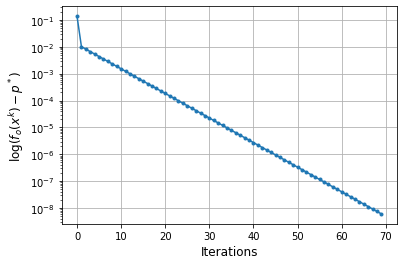

In [49]:
plt.yscale('log') #escala logarítmica en el eje vertical
plt.plot(np.arange(Err_plot.size),Err_plot,'.-')
plt.ylabel('$\log(f_o(x^k)-p^*)$',size=12)
plt.xlabel('Iterations',size=12)
plt.grid()
plt.show()

In [50]:
x_plot[:,-1]

array([-4.99999993e-09,  3.48094310e-04])

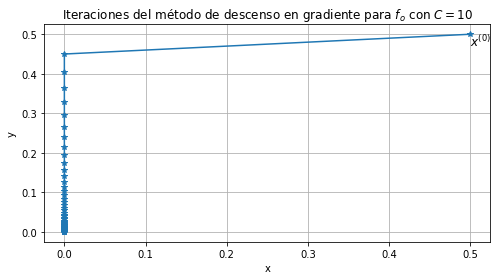

In [51]:
plt.figure(figsize=(8,4))
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.ylabel('y')
plt.xlabel('x')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12,xytext=(0.5, 0.47))
plt.title('Iteraciones del método de descenso en gradiente para $f_o$ con $C=10$')
plt.grid()
plt.show()

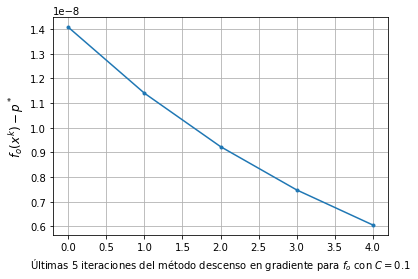

In [52]:
plt.plot(np.arange(Err_plot.size-65),Err_plot[65:],'.-')
plt.ylabel('$f_o(x^k)-p^*$',size=12)
plt.xlabel('Últimas 5 iteraciones del método descenso en gradiente para $f_o$ con $C=0.1$')
plt.grid()
plt.show()

**Comentario:** en esta gráfica se observa una convergencia **lineal** del método de descenso en gradiente para $f_o$.

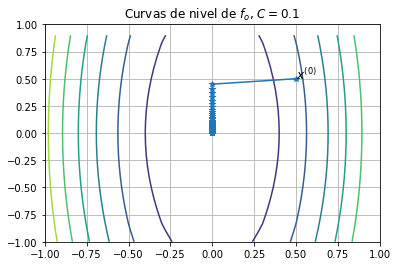

In [53]:
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.contour(x_p,y_p,z(x_mesh,y_mesh,cte))
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.title("Curvas de nivel de $f_o$, $C=0.1$")
plt.grid()
plt.show()

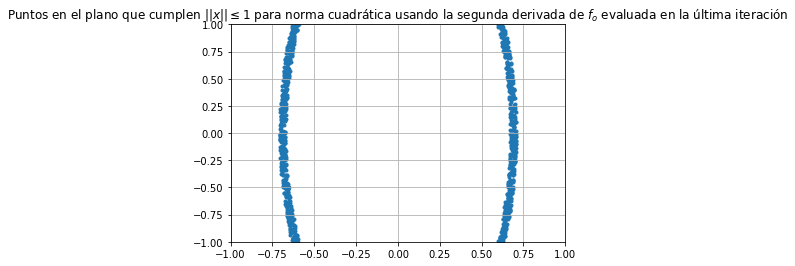

In [54]:
x_k = x_plot[:,-1].reshape(2,1)
Hf_x_k = Hessian_approximation(fo,x_k)
norm_cuad = lambda z : np.sum((z-x_k)*(Hf_x_k@(z-x_k)),axis=0)
density_p=int(2.5*10**4)
z_p=np.random.uniform(-1,1,(2,density_p))
lim_sup=.5
lim_inf=.45
ind=(norm_cuad(z_p)<=lim_sup) & (lim_inf<=norm_cuad(z_p))
z_p_subset = z_p[:,ind]
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter(z_p_subset[0,:],z_p_subset[1,:],marker='.')
plt.title('Puntos en el plano que cumplen $||x|| \leq 1$ para norma cuadrática usando la segunda derivada de $f_o$ evaluada en la última iteración')
plt.grid()
plt.show()

In [55]:
np.linalg.cond(Hf_x_k)

10.000000000033086

**La matriz Hessiana es medianamente bien condicionada**

**Comentarios:**

* El número de condición de la matriz Hessiana de la función $f_o(x) = \frac{1}{2}\left ( x_1^2 + Cx_2^2 \right)$ es igual a $\max\left\{C, \frac{1}{C}\right\}$ lo cual se obtiene del cociente del eigenvalor máximo entre el eigenvalor mínimo de $\nabla ^2f_o(x)$: $\frac{\max\{1,C\}}{\min\{1,C\}}$ ya que $\nabla ^2 f_o(x)$ es una matriz diagonal y positiva definida pues $C>0$: $\nabla^2f_o(x)=\left [\begin{array}{cc}
1 & 0\\
0 & C\\
\end{array}
\right]
$ $\forall x \in \mathbb{R}^2$.

* Por el punto anterior el número de condición de la matriz Hessiana es grande si $C >> 1$ o $C <<1$. 

* El número de condición de la matriz Hessiana se observa que influye mucho en la convergencia del método de descenso en gradiente. Aún siendo la Hessiana medianamente bien condicionadas (número de condición igual a 10 con $C=10$ o $C=0.1$) el número de iteraciones cambió drásticamente (un número de iteraciones mayor a $50$). Esto se cumple para este método y el método más general: el método de descenso más pronunciado: ***steepest descent method***. Para matrices mal condicionadas el método de gradiente es muy lento por lo que no se recomienda en la práctica.

* La simplicidad del método de descenso en gradiente es su mayor ventaja pero su enorme dependencia en el número de condición en la Hessiana o los conjuntos subnivel es su desventaja.

* La elección de valores en los parámetros de búsqueda de línea por *backtracking* $\alpha$ y $\beta$ tienen un efecto visible pero **no dramático** en la convergencia. Típicamente se utilizan $\alpha=0.01, 0.15$ y $\beta = 0.5$.

**Ejercicio: realizar mismas gráficas y análisis de convergencia y curvas de nivel para la función objetivo $f_o(x) = \frac{1}{2}\left ( Cx_1^2 + x_2^2 \right)$ para $C=10^{-2}, 10^2$**.

### Método de descenso en gradiente visto como caso particular del método *steepest descent* bajo la norma cuadrática

>**Algoritmo de descenso en gradiente (visto como un caso particular del método *steepest descent* para matrices simétricas definidas positivas)**
>> **Dado** un **punto inicial** $x$ en $\text{dom}f_o$

>> **Repetir** el siguiente bloque para $k=0,1,2,...$

>>> 1. Definir $P$ matriz simétrica definida positiva.
>>> 2. Transformar $\hat{x}$ con: $x = P^{-1/2} \hat{x}$ con $\hat{x}$ variable del problema transformado\*.
>>> 3. Calcular la dirección de descenso en gradiente $\Delta x = -  \nabla f_o(x)$.
>>> 4. Búsqueda de línea. Elegir un tamaño de paso $t > 0$.
>>> 5. Hacer la actualización: $x = x + t\Delta x$.

>> **hasta** convergencia (satisfacer criterio de paro).


\*El problema transformado bajo $P$ es:

$$min \hat{f}_o(\hat{x})$$

con $\hat{f}_o (\hat{x}) = f_o(P^{-1/2}\hat{x}) = f_o(x)$ y $x$ variable "original": $\hat{x} = P^{1/2}x$.

Entonces aplicamos descenso en gradiente a $f_o$ pero transformando los datos de entrada de $f_o$ por la matriz raíz cuadrada simétrica\* $P^{-1/2}$.

\*$P^{1/2}$ se nombra **raíz cuadrada simétrica** o ***symmetric squareroot*** y está definida para matrices $P$ simétricas semidefinidas positivas como $P^{1/2}=Qdiag(\lambda_1^{1/2},\dots,\lambda_n^{1/2})Q^T$ con $Q$ y $diag(\lambda_1^{1/2},\dots,\lambda_n^{1/2})$ obtenidas con la **descomposición espectral** de $P$, ver [3.3.d.SVD](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/III.computo_matricial/3.3.d.SVD.ipynb).

<img src="https://dl.dropboxusercontent.com/s/91qivndznw2xfgb/steepest_descent_quadratic_norm.png?dl=0" heigth="750" width="750">

## Ejemplo

1) $$\min \quad e^{(x_1+3x_2-0.1)}+e^{x_1-3x_2-0.1}+e^{-x_1-0.1}$$

a)Usando $P_1=\left [\begin{array}{cc}
1 & 0\\
0 & 1\\
\end{array}
\right]
$ por lo que no hay transformación de coordenadas.

In [56]:
P=np.eye(2)

In [57]:
P

array([[1., 0.],
       [0., 1.]])

In [58]:
def coord_transform(x):
    eigenvalues, eigenvectors = np.linalg.eig(P)       
    return eigenvectors@((eigenvalues**(-1/2))*(np.transpose(eigenvectors)@x))

In [59]:
fo = lambda x: math.exp(x[0]+3*x[1]-0.1)+math.exp(x[0]-3*x[1]-0.1)+math.exp(-x[0]-0.1)

In [60]:
fo_transf = lambda x: fo(coord_transform(x))

In [61]:
x_ast = np.array([-3.4654e-01,-7.6725e-06],dtype=float)


In [62]:
x_ast = coord_transform(np.array([-3.4654e-01,-7.6725e-06],dtype=float))


In [63]:
x_ast

array([-3.4654e-01, -7.6725e-06])

In [64]:
x_0 = np.array([0,0],dtype=float)
tol=1e-8
tol_backtracking=1e-14
maxiter=50
p_ast=fo_transf(x_ast)

[x,total_of_iterations,Err_plot,x_plot]=gradient_descent(fo_transf, x_0,tol, tol_backtracking, x_ast, p_ast, maxiter)


I    Normagf   Error x_ast   Error p_ast   line search
0    9.05e-01    1.00e+00    1.55e-01     ---
1    2.71e-01    3.06e-01    1.43e-02     5.00e-01
2    7.64e-02    8.60e-02    1.14e-03     5.00e-01
3    2.14e-02    2.42e-02    8.93e-05     5.00e-01
4    5.98e-03    6.64e-03    6.98e-06     5.00e-01
5    1.68e-03    1.98e-03    5.46e-07     5.00e-01
6    1.07e-03    5.04e-04    8.08e-08     5.00e-01
7    5.28e-04    2.75e-04    2.57e-08     1.25e-01
8    2.85e-04    1.62e-04    8.84e-09     1.25e-01
9    3.57e-04    6.58e-05    4.68e-09     2.50e-01
10    1.62e-04    7.11e-05    2.17e-10     1.25e-01
11    7.64e-05    5.66e-05    1.33e-09     1.25e-01
12    3.85e-05    7.54e-05    1.63e-09     1.25e-01
13    2.12e-05    8.04e-05    1.72e-09     1.25e-01
14    2.54e-05    9.45e-05    1.75e-09     2.50e-01
15    1.16e-05    9.43e-05    1.77e-09     1.25e-01
16    5.53e-06    9.67e-05    1.78e-09     1.25e-01
17    2.86e-06    9.72e-05    1.78e-09     1.25e-01
18    1.56e-06    9.81e-

In [65]:
x

array([-3.46573595e-01, -5.55111512e-09])

In [66]:
total_of_iterations

29

In [67]:
Err_plot.shape

(29,)

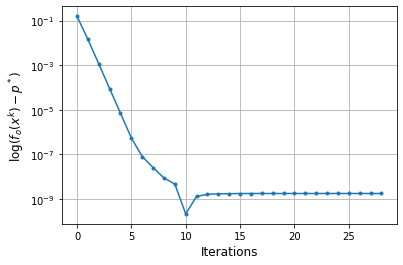

In [68]:
plt.yscale('log') #escala logarítmica en el eje vertical
plt.plot(np.arange(Err_plot.size),Err_plot,'.-')
plt.ylabel('$\log(f_o(x^k)-p^*)$',size=12)
plt.xlabel('Iterations',size=12)
plt.grid()
plt.show()

In [69]:
x_plot.shape

(2, 29)

In [70]:
x_plot[:,0]

array([0., 0.])

In [71]:
x_plot[:,-1]

array([-3.46573595e-01, -5.55111512e-09])

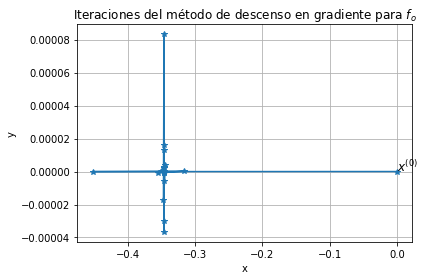

In [72]:
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.ylabel('y')
plt.xlabel('x')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.title('Iteraciones del método de descenso en gradiente para $f_o$')
plt.grid()
plt.show()

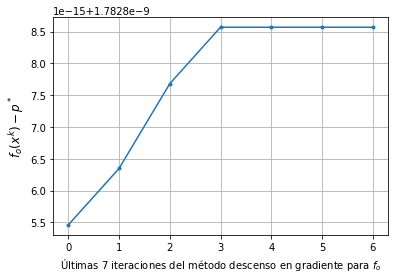

In [73]:
plt.plot(np.arange(Err_plot.size-22),Err_plot[22:],'.-')
plt.ylabel('$f_o(x^k)-p^*$',size=12)
plt.xlabel('Últimas 7 iteraciones del método descenso en gradiente para $f_o$')
plt.grid()
plt.show()

**Comentario:** en esta gráfica se observa una convergencia **lineal** del método de descenso en gradiente para $f_o$.

**Curvas de nivel de $f_o$**

In [74]:
z=lambda x_mesh,y_mesh: np.exp(x_mesh+3*y_mesh-0.1)+np.exp(x_mesh-3*y_mesh-0.1)+np.exp(-x_mesh-0.1)

In [75]:
def coord_transform_2(x):
    eigenvalues, eigenvectors = np.linalg.eig(P)      
    return eigenvectors@((eigenvalues**(-1/2)).reshape(x.shape[0],1)*(eigenvectors@x))

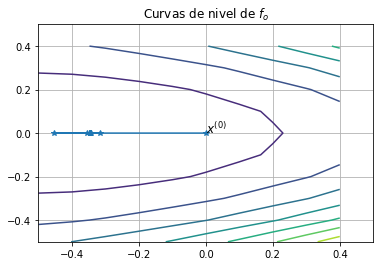

In [76]:
density=1e-1
xl=-.5
yl=-.5
xr=.5
yr=.5
x_p=np.arange(xl,xr,density)
y_p=np.arange(yl,yr,density)
x_y_p_t = coord_transform_2(np.row_stack((x_p,y_p)))
x_p_t = x_y_p_t[0,:]
y_p_t = x_y_p_t[1,:]
x_mesh,y_mesh = np.meshgrid(x_p_t,y_p_t)
plt.xlim(-.5, .5)
plt.ylim(-.5, .5)
plt.contour(x_p,y_p,z(x_mesh,y_mesh))
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.grid()
plt.title("Curvas de nivel de $f_o$")
plt.show()

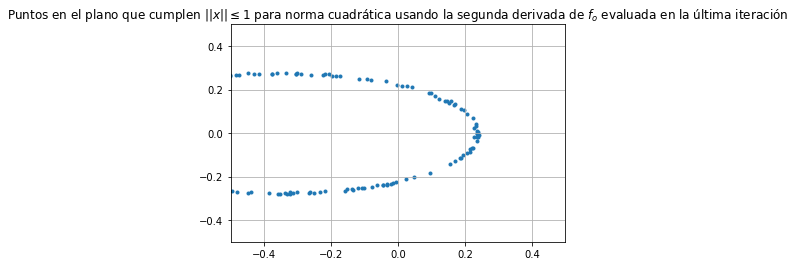

In [77]:
x_k = x_plot[:,-1]
Hf_x_k = Hessian_approximation(fo_transf,x_k)
x_k = x_k.reshape(2,1)
norm_cuad = lambda z : np.sum((z-x_k)*(Hf_x_k@(z-x_k)),axis=0)
density_p=int(2.5*10**4)
z_p=np.random.uniform(-1,1,(2,density_p))
lim_sup=.9
lim_inf=.85
ind=(norm_cuad(z_p)<=lim_sup) & (lim_inf<=norm_cuad(z_p))
z_p_subset = z_p[:,ind]
plt.xlim(-.5, .5)
plt.ylim(-.5, .5)
plt.scatter(z_p_subset[0,:],z_p_subset[1,:],marker='.')
plt.title('Puntos en el plano que cumplen $||x|| \leq 1$ para norma cuadrática usando la segunda derivada de $f_o$ evaluada en la última iteración')
plt.grid()
plt.show()

In [78]:
np.linalg.cond(Hf_x_k)

4.500694250729451

**La matriz Hessiana está bien condicionada**.

**En los siguientes ejemplos continuamos usando el método de descenso en gradiente pero con diferentes matrices de transformación para el método de *steepest descent* bajo la norma cuadrática y ver su influencia en las curvas de nivel y en el número de condición de la Hessiana.**

3) Usando $P_1=\left [\begin{array}{cc}
2 & 0\\
0 & 8\\
\end{array}
\right]
$ para transformar a $f_0$.

In [79]:
P=np.array([[2,0],
            [0,8]])

In [80]:
P

array([[2, 0],
       [0, 8]])

In [81]:
x_ast = np.array([-3.4654e-01,-7.6725e-06],dtype=float)

In [82]:
x_ast = coord_transform(np.array([-3.4654e-01,-7.6725e-06],dtype=float))


In [83]:
x_ast

array([-2.45040784e-01, -2.71263839e-06])

In [84]:
x_0 = np.array([0,0],dtype=float)
tol=1e-8
tol_backtracking=1e-14
maxiter=50
p_ast=fo_transf(x_ast)

[x,total_of_iterations,Err_plot,x_plot]=gradient_descent(fo_transf, x_0,tol, tol_backtracking, x_ast, p_ast, maxiter)


I    Normagf   Error x_ast   Error p_ast   line search
0    6.40e-01    1.00e+00    1.17e-01     ---
1    1.92e-01    1.61e+00    2.42e-02     1.00e+00
2    5.40e-02    8.28e-01    3.74e-02     1.00e+00
3    1.51e-02    1.05e+00    3.84e-02     1.00e+00
4    4.23e-03    9.87e-01    3.85e-02     1.00e+00
5    1.18e-03    1.00e+00    3.85e-02     1.00e+00
6    3.31e-04    9.99e-01    3.85e-02     1.00e+00
7    9.25e-05    1.00e+00    3.85e-02     1.00e+00
8    2.59e-05    1.00e+00    3.85e-02     1.00e+00
9    7.28e-06    1.00e+00    3.85e-02     1.00e+00
10    2.00e-06    1.00e+00    3.85e-02     1.00e+00
11    4.91e-07    1.00e+00    3.85e-02     1.00e+00
12    1.26e-07    1.00e+00    3.85e-02     1.00e+00
13    8.88e-08    1.00e+00    3.85e-02     1.00e+00
14    4.44e-08    1.00e+00    3.85e-02     5.00e-01
15    4.44e-08    1.00e+00    3.85e-02     3.91e-03
16    0.00e+00    1.00e+00    3.85e-02     3.12e-02
Error of x with respect to x_ast: 1.00e+00
Approximate solution: [-4.9012909

In [85]:
x

array([-4.90129093e-01, -1.56125113e-09])

In [86]:
total_of_iterations

17

In [87]:
Err_plot.shape

(17,)

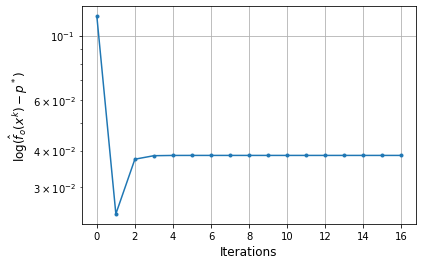

In [88]:
plt.yscale('log') #escala logarítmica en el eje vertical
plt.plot(np.arange(Err_plot.size),Err_plot,'.-')
plt.ylabel('$\log(\hat{f}_o(x^k)-p^*)$',size=12)
plt.xlabel('Iterations',size=12)
plt.grid()
plt.show()

In [89]:
x_plot.shape

(2, 17)

In [90]:
x_plot[:,0]

array([0., 0.])

In [91]:
x_plot[:,-1]

array([-4.90129093e-01, -1.56125113e-09])

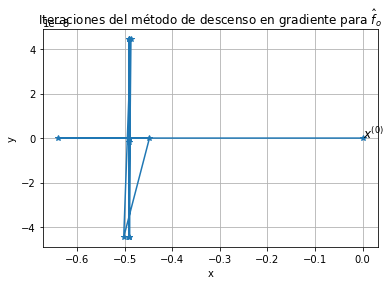

In [92]:
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.ylabel('y')
plt.xlabel('x')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.title('Iteraciones del método de descenso en gradiente para $\hat{f}_o$')
plt.grid()
plt.show()

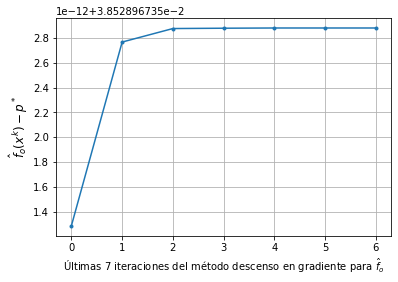

In [93]:
plt.plot(np.arange(Err_plot.size-10),Err_plot[10:],'.-')
plt.ylabel('$\hat{f}_o(x^k)-p^*$',size=12)
plt.xlabel('Últimas 7 iteraciones del método descenso en gradiente para $\hat{f}_o$')
plt.grid()
plt.show()

**Comentario:** en esta gráfica se observa una convergencia **lineal** del método de descenso en gradiente para $f_o$ transformada.

**Curvas de nivel de $f_o$ transformada**

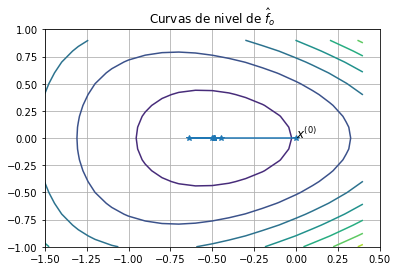

In [94]:
density=1e-1
xl=-1.5
yl=-1
xr=.5
yr=1
x_p=np.arange(xl,xr,density)
y_p=np.arange(yl,yr,density)
x_y_p_t = coord_transform_2(np.row_stack((x_p,y_p)))
x_p_t = x_y_p_t[0,:]
y_p_t = x_y_p_t[1,:]
x_mesh,y_mesh = np.meshgrid(x_p_t,y_p_t)
plt.xlim(-1.5, .5)
plt.ylim(-1, 1)
plt.contour(x_p,y_p,z(x_mesh,y_mesh))
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.grid()
plt.title("Curvas de nivel de $\hat{f}_o$")
plt.show()

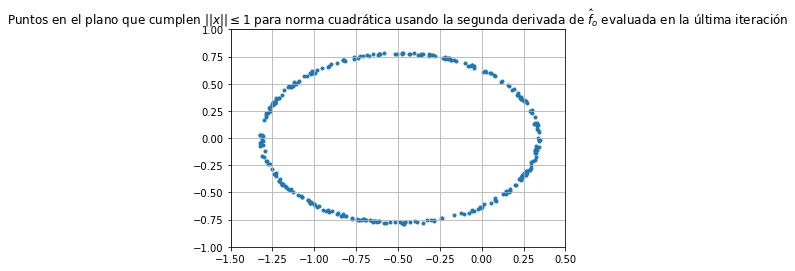

In [95]:
x_k = x_plot[:,-1]
Hf_x_k = Hessian_approximation(fo_transf,x_k)
x_k = x_k.reshape(2,1)
norm_cuad = lambda z : np.sum((z-x_k)*(Hf_x_k@(z-x_k)),axis=0)
density_p=int(2.5*10**4)
z_p=np.random.uniform(-2,1,(2,density_p))
lim_sup=.9
lim_inf=.85
ind=(norm_cuad(z_p)<=lim_sup) & (lim_inf<=norm_cuad(z_p))
z_p_subset = z_p[:,ind]
plt.xlim(-1.5, .5)
plt.ylim(-1, 1)
plt.scatter(z_p_subset[0,:],z_p_subset[1,:],marker='.')
plt.title('Puntos en el plano que cumplen $||x|| \leq 1$ para norma cuadrática usando la segunda derivada de $\hat{f}_o$ evaluada en la última iteración')
plt.grid()
plt.show()

In [96]:
np.linalg.cond(Hf_x_k)

1.124913254684247

**Obsérvese que es menor el número de condición con la transformación de $f_o$**.

c) Usando $P_2=\left [\begin{array}{cc}
8 & 0\\
0 & 2\\
\end{array}
\right]
$ para transformar a $f_o$.

In [97]:
P=np.array([[8,0],
            [0,2]])

In [98]:
P

array([[8, 0],
       [0, 2]])

In [99]:
x_ast = np.array([-3.4654e-01,-7.6725e-06],dtype=float)

In [100]:
x_ast = coord_transform(np.array([-3.4654e-01,-7.6725e-06],dtype=float))


In [101]:
x_ast

array([-1.22520392e-01, -5.42527678e-06])

In [102]:
x_0 = np.array([0,0],dtype=float)
tol=1e-8
tol_backtracking=1e-14
maxiter=60
p_ast=fo_transf(x_ast)

[x,total_of_iterations,Err_plot,x_plot]=gradient_descent(fo_transf, x_0,tol, tol_backtracking, x_ast, p_ast, maxiter)


I    Normagf   Error x_ast   Error p_ast   line search
0    3.20e-01    1.00e+00    3.67e-02     ---
1    2.13e-01    1.61e+00    4.85e-02     1.00e+00
2    1.44e-01    3.35e+00    8.65e-02     1.00e+00
3    9.73e-02    4.52e+00    1.04e-01     1.00e+00
4    6.60e-02    5.32e+00    1.12e-01     1.00e+00
5    4.49e-02    5.86e+00    1.15e-01     1.00e+00
6    3.05e-02    6.22e+00    1.17e-01     1.00e+00
7    2.08e-02    6.47e+00    1.18e-01     1.00e+00
8    1.48e-02    6.64e+00    1.18e-01     1.00e+00
9    2.41e-02    6.76e+00    1.18e-01     1.00e+00
10    1.34e-02    6.78e+00    1.18e-01     2.50e-01
11    9.31e-03    6.79e+00    1.18e-01     2.50e-01
12    2.25e-02    6.86e+00    1.18e-01     1.00e+00
13    1.10e-02    6.87e+00    1.19e-01     2.50e-01
14    6.41e-03    6.88e+00    1.19e-01     2.50e-01
15    9.18e-03    6.90e+00    1.19e-01     5.00e-01
16    5.17e-03    6.91e+00    1.19e-01     2.50e-01
17    7.62e-03    6.92e+00    1.19e-01     5.00e-01
18    4.17e-03    6.93e+

In [103]:
x

array([-9.80231973e-01,  2.89768209e-06])

In [104]:
total_of_iterations

60

In [105]:
Err_plot.shape

(60,)

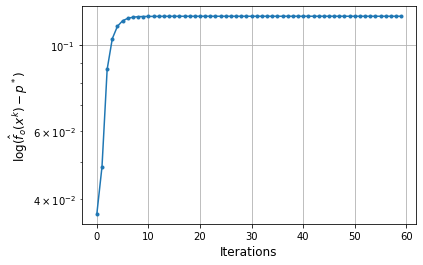

In [106]:
plt.yscale('log') #escala logarítmica en el eje vertical
plt.plot(np.arange(Err_plot.size),Err_plot,'.-')
plt.ylabel('$\log(\hat{f}_o(x^k)-p^*)$',size=12)
plt.xlabel('Iterations',size=12)
plt.grid()
plt.show()

In [107]:
x_plot.shape

(2, 60)

In [108]:
x_plot[:,0]

array([0., 0.])

In [109]:
x_plot[:,-1]

array([-9.80231973e-01,  2.89768209e-06])

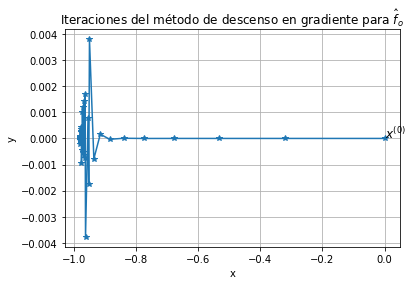

In [110]:
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.ylabel('y')
plt.xlabel('x')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.title('Iteraciones del método de descenso en gradiente para $\hat{f}_o$')
plt.grid()
plt.show()

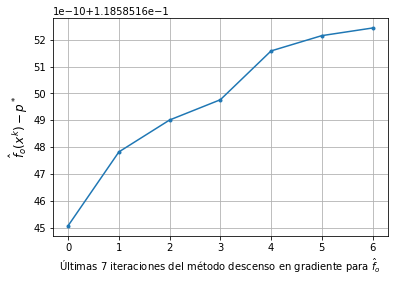

In [111]:
plt.plot(np.arange(Err_plot.size-53),Err_plot[53:],'.-')
plt.ylabel('$\hat{f}_o(x^k)-p^*$',size=12)
plt.xlabel('Últimas 7 iteraciones del método descenso en gradiente para $\hat{f}_o$')
plt.grid()
plt.show()

**Comentario:** en esta gráfica se observa una convergencia **lineal** del método de descenso en gradiente para $f_o$ transformada.

**Curvas de nivel de $f_o$ transformada**

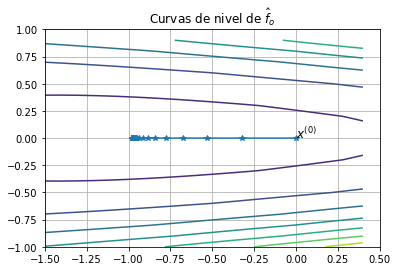

In [112]:
density=1e-1
xl=-1.5
yl=-1
xr=.5
yr=1
x_p=np.arange(xl,xr,density)
y_p=np.arange(yl,yr,density)
x_y_p_t = coord_transform_2(np.row_stack((x_p,y_p)))
x_p_t = x_y_p_t[0,:]
y_p_t = x_y_p_t[1,:]
x_mesh,y_mesh = np.meshgrid(x_p_t,y_p_t)
plt.xlim(-1.5, .5)
plt.ylim(-1, 1)
plt.contour(x_p,y_p,z(x_mesh,y_mesh))
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.grid()
plt.title("Curvas de nivel de $\hat{f}_o$")
plt.show()

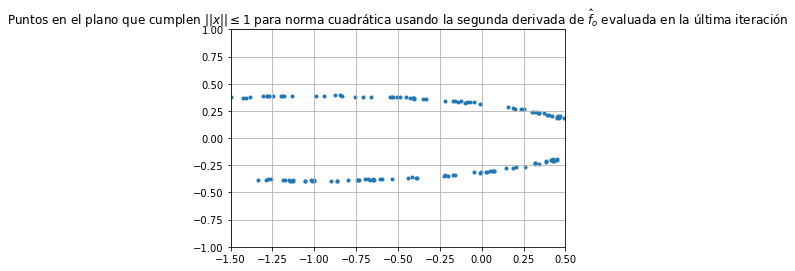

In [113]:
x_k = x_plot[:,-1]
Hf_x_k = Hessian_approximation(fo_transf,x_k)
x_k = x_k.reshape(2,1)
norm_cuad = lambda z : np.sum((z-x_k)*(Hf_x_k@(z-x_k)),axis=0)
density_p=int(2.5*10**4)
z_p=np.random.uniform(-2,1,(2,density_p))
lim_sup=.9
lim_inf=.85
ind=(norm_cuad(z_p)<=lim_sup) & (lim_inf<=norm_cuad(z_p))
z_p_subset = z_p[:,ind]
plt.xlim(-1.5, .5)
plt.ylim(-1, 1)
plt.scatter(z_p_subset[0,:],z_p_subset[1,:],marker='.')
plt.title('Puntos en el plano que cumplen $||x|| \leq 1$ para norma cuadrática usando la segunda derivada de $\hat{f}_o$ evaluada en la última iteración')
plt.grid()
plt.show()

In [127]:
np.linalg.cond(Hf_x_k)

18.011111111111113

**Obsérvese que es mayor el número de condición con la transformación de $f_o$**.

**Comentarios:**

* Como se observa en los ejemplos anteriores la elección de la norma en el método de descenso más pronunciado tiene un efecto fuerte en la tasa de convergencia. 

* Siempre existe una matriz $P$ para la cual el método de descenso más pronunciado tiene una convergencia buena. El reto está en encontrar tal matriz. La idea es identificar una matriz $P$ para la cual el problema transformado tenga un número de condición moderado.

**Referencias:**

* S. P. Boyd, L. Vandenberghe, Convex Optimization, Cambridge University Press, 2009.
